In [1]:
from pathlib import Path
%matplotlib widget 
import matplotlib.pyplot as plt
import lightkurve as lk
from utility import *

In [2]:
# The following are good for clear primary & secondary eclipses and detrending through flattening;
# TIC141685465, TIC167692429, TIC307488184. TIC355152640, TIC382517745, TIC260132330

# TIC300560295 shows flattening removing pulsations but the secondary is not clear

# TIC308851582 looks like the analysis hasn't picked up the secondary correctly
# TIC341193555 - wrong secondary eclipse

# TIC350518984 has zero eclipse widths - also cannot see a secondary
# TIC372909935 has zero eclipse widths

# TIC031273263 - look into where the secondary is

# TIC309658221 - noisy but analysis should work

# TIC140659980 has good eclipses and potentially interesting residuals

# TIC167692429 - some variability in eclipse timings 
target = "TIC407661994"
flux_column = "pdcsap_flux"
quality_bitmask = "default"
sectors = []
eclipse_dur_multiple = 1.

input_file = Path(".") / "tessebs_extra.csv"
catalogue_dir = Path(".") / "catalogue"
analysis_dir = catalogue_dir / "analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Get the target's basic details. StopIteration will be raised if the target is unknown
target, target_row, _ = next(iterate_targets(input_file, index_filter=[target]))
tic = target_row["TIC"]

# We need the analysis output, as that contains the eclipse timing data
analysis_csv = analysis_dir / f"{tic}_analysis" / f"{tic}_analysis_summary.csv"
echo_analysis_log(analysis_csv.parent / f"{tic}.log")
eclipses = parse_analysis_for_eclipses(analysis_csv, duration_scale=eclipse_dur_multiple)
if not eclipses:
    print(f"Did not find '{analysis_csv}'. Unable to process {target}. Skipping.")
else:
    (t0, period, ecl_times, ecl_durs) = eclipses
    if t0 is None or t0 <= 0.:
        print("Analysis didn't give a reference time so querying TESS-ebs for one")
        t0, _ = lookup_tess_ebs_ephemeris(target, tic)
        if t0:
            print(f"Using reference time from TESS-ebs of {t0:.6f} for eclipse timings.")
            ecl_times = [et + t0 for et in ecl_times]


Analysis Log:
2024-03-16 06:50:31 INFO main_functions - analyse_light_curve: Start of analysis
2024-03-16 07:04:37 INFO main_functions - analyse_frequencies: Frequency extraction done. Total time elapsed: 846.0s.
2024-03-16 07:09:25 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 288.2s.
2024-03-16 07:09:34 INFO main_functions - analyse_light_curve: Dividing period by 2, redoing some steps
2024-03-16 07:13:42 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 248.3s.
2024-03-16 07:19:32 INFO main_functions - analyse_light_curve: End of analysis. Total time elapsed: 1740.3s.
From 407661994_analysis_summary.csv
Reference time:              2209.495774+/-0
Orbital period:              12.555753+/-0.000022
Eclipse times:               2225.173657+/-0.000766, 2231.451853+/-0.003479
Eclipse durations:           0.178518+/-0.001532, 0.156671+/-0.006958


In [4]:
lcs = None
if eclipses:
    # Load, filter and then process the requested sectors for this target.
    download_dir = catalogue_dir / f"download/{tic}/"
    fits = sorted(download_dir.rglob("**/*.fits"))
    lcs = lk.LightCurveCollection([
        lk.read(f"{f}", flux_column=flux_column, quality_bitmask=quality_bitmask) for f in fits])
    print(f"Loaded {len(lcs)} light curve fits file(s) for {target}.")

Loaded 17 light curve fits file(s) for TIC407661994.


In [5]:
if lcs:
    # Load, filter and then process the requested sectors for this target.
    download_dir = catalogue_dir / f"download/{tic}/"
    fits = sorted(download_dir.rglob("**/*.fits"))
    lcs = lk.LightCurveCollection([
        lk.read(f"{f}", flux_column=flux_column, quality_bitmask=quality_bitmask) for f in fits])

    variabilities = []
    for lc in [l for l in lcs if len(sectors) == 0 or l.sector in sectors]:
        print(f"Processing sector {lc.sector:03d} {flux_column}...", end="")

        # Process the light curve to find the variability metric for this sector
        print("normalizing...", end="")
        lc = lc.normalize()

        print("flattening the light curve...", end="")
        flat_lc, res_lc, ecl_mask = flatten_lightcurve(lc, ecl_times, ecl_durs, period, False)
        variability = calculate_variability_metric(res_lc)
        variabilities.append(variability)
        print(f"variability metric = {variability:.6f}")

    # Calculating the variability by sector & taking the mean/stddev appears
    # more reliable than stitching the res_lcs and calculating the metric directly.
    # The stitched resids suffer from large discursions absent from the source lcs.
    print("\nThe overall variability metric =",
            f"{np.mean(variabilities):.6f}+/-{np.std(variabilities):.6f}\n")

Processing sector 004 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001221
Processing sector 005 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001156
Processing sector 006 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001436
Processing sector 007 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001242
Processing sector 008 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001114
Processing sector 009 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001330
Processing sector 011 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001260
Processing sector 012 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001234
Processing sector 013 pdcsap_flux...normalizing...flattening the light curve...variability metric = 0.001505
Processing sector 0

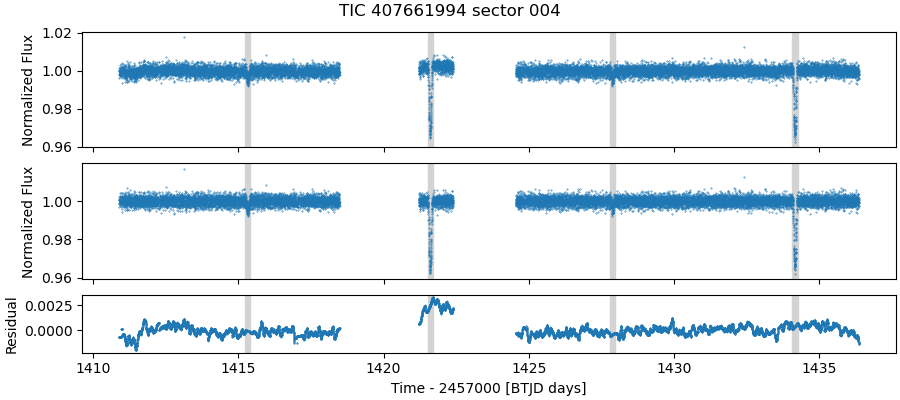

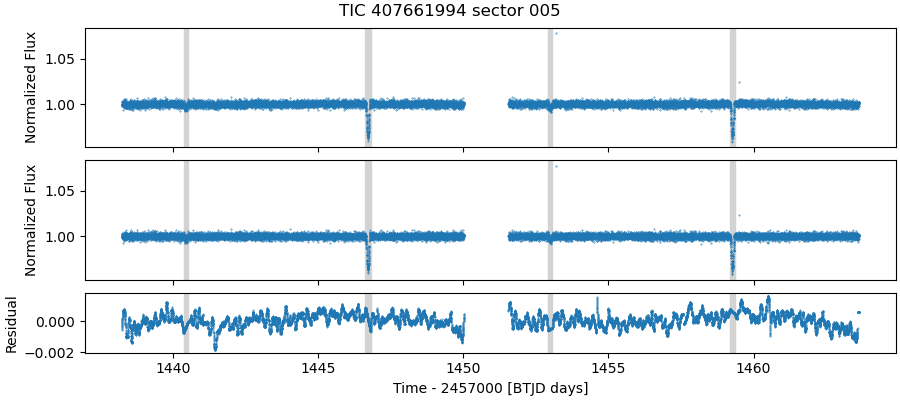

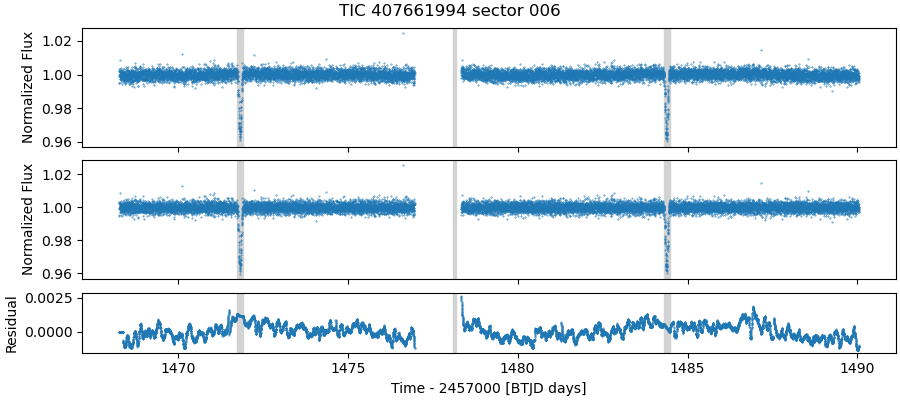

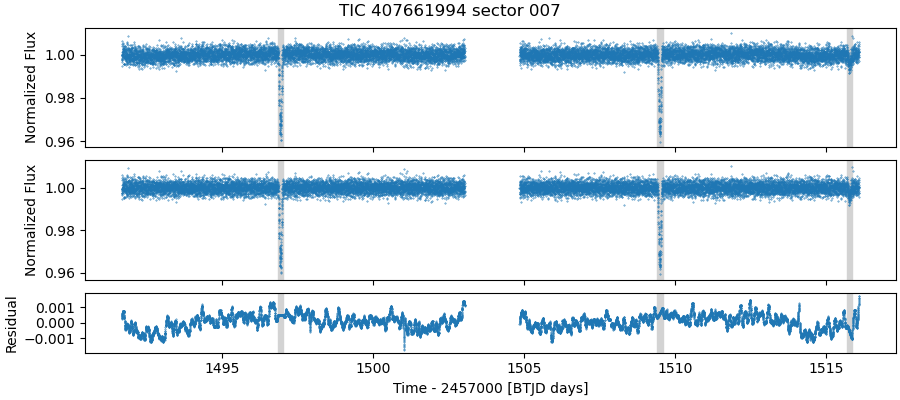

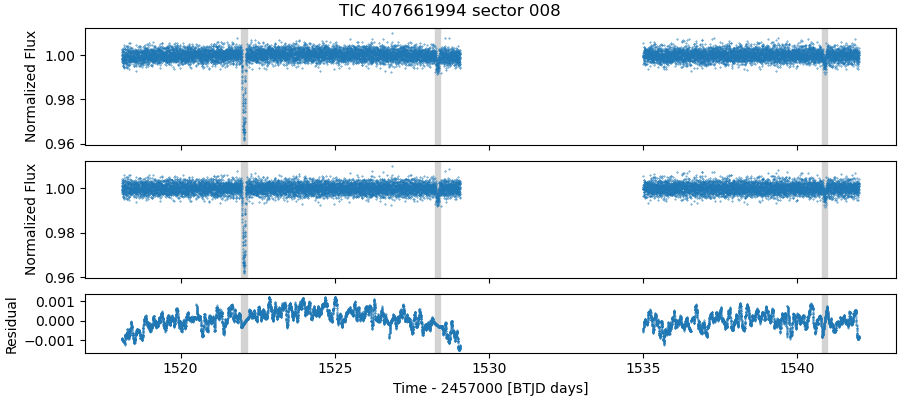

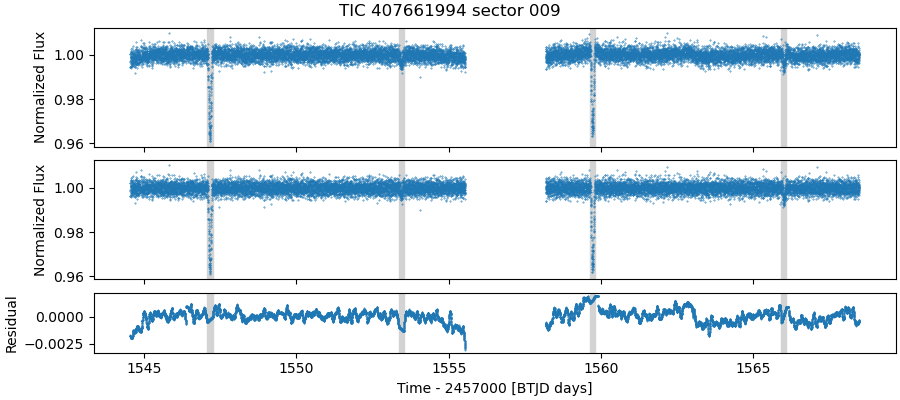

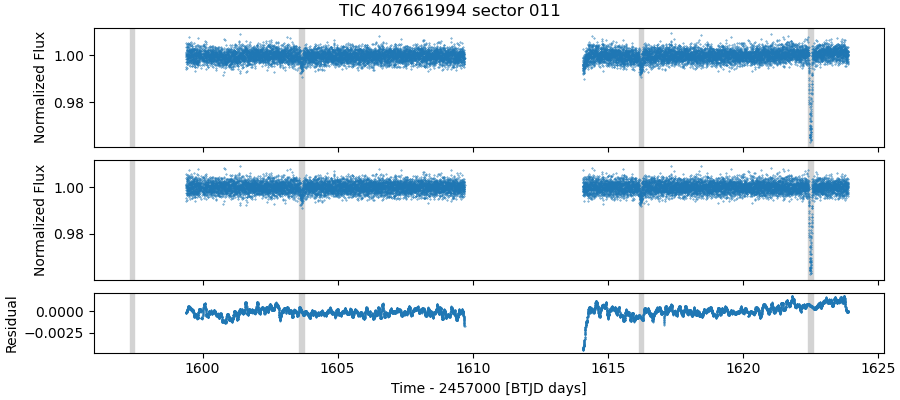

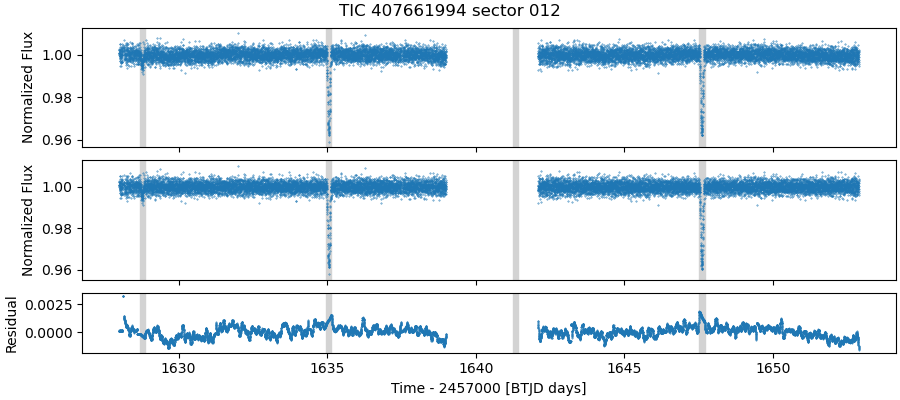

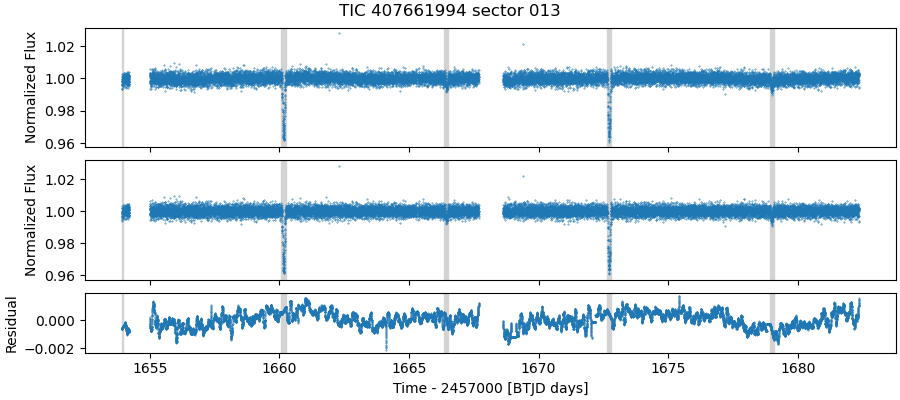

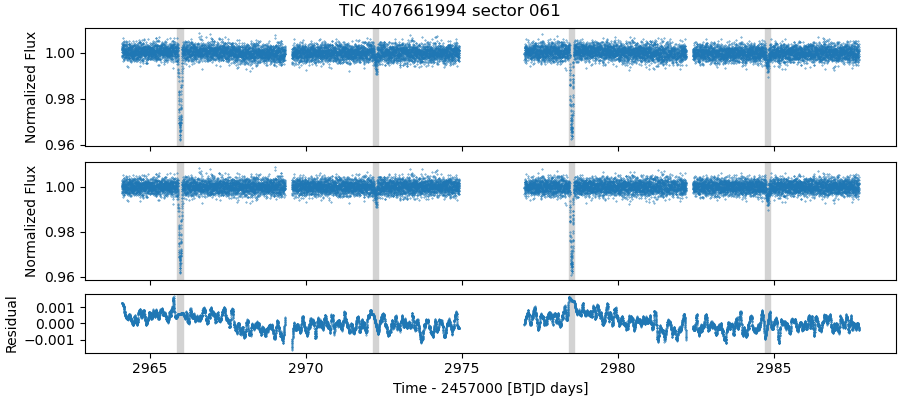

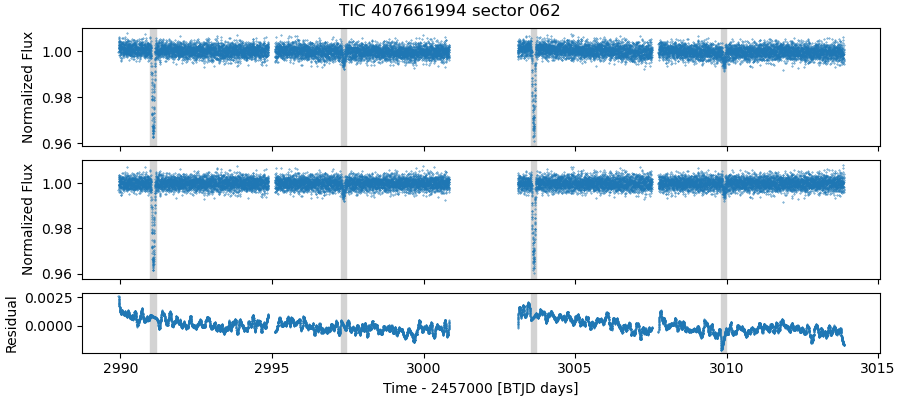

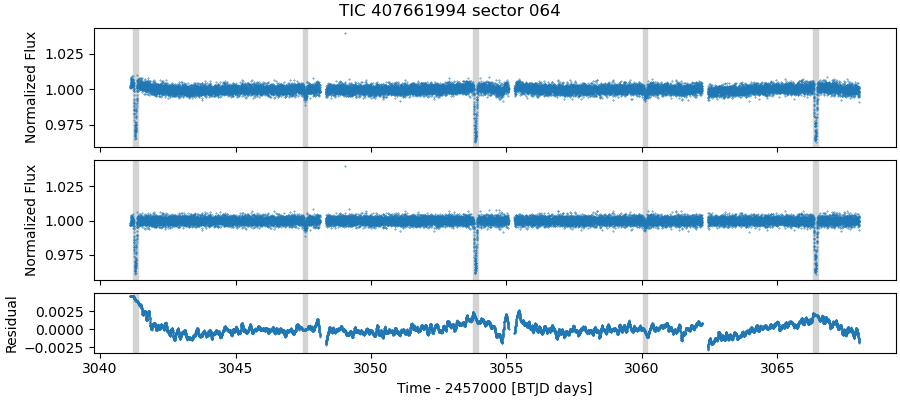

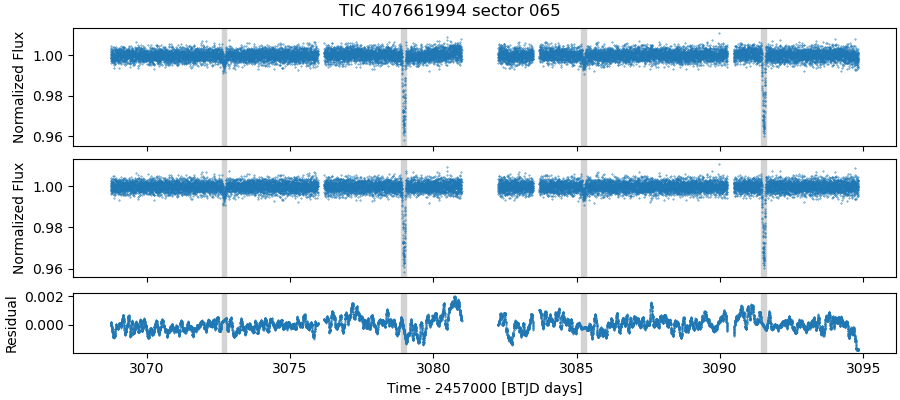

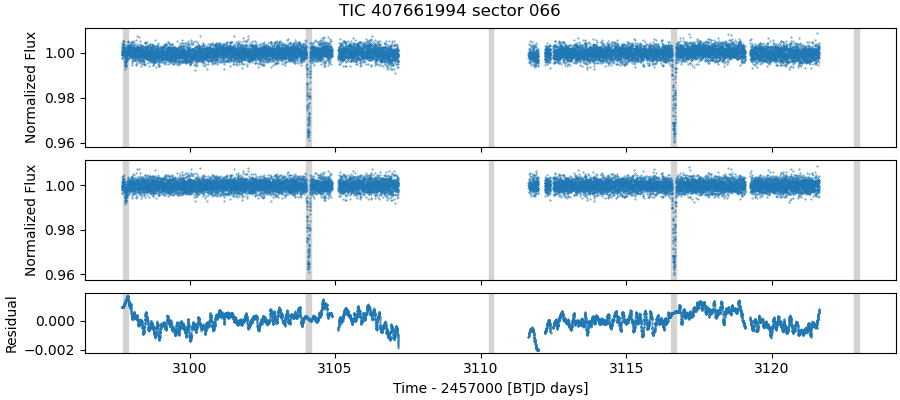

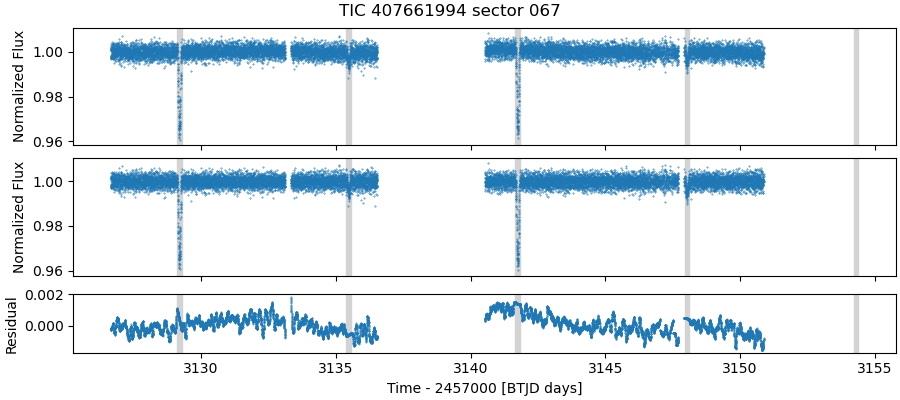

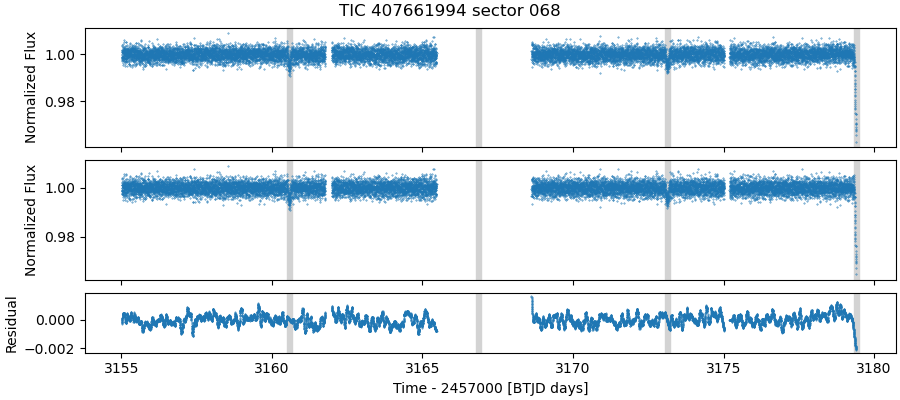

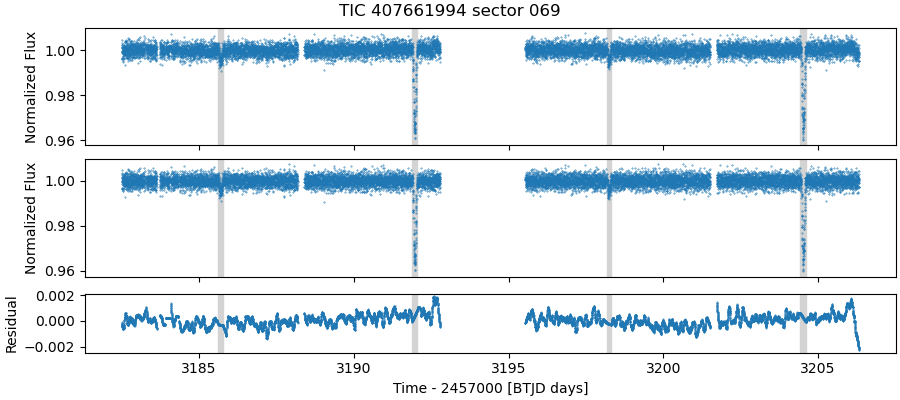

In [6]:
if lcs:
    for lc in [l for l in lcs if len(sectors) == 0 or l.sector in sectors]:
        lc = lc.normalize()
        flat_lc, res_lc, ecl_mask = flatten_lightcurve(lc, ecl_times, ecl_durs, period, False)
        
        title = f"{lc.meta['OBJECT']} sector {lc.sector:03d}"
        fig, _ = plot_lightcurves_and_mask(lc, flat_lc, res_lc, ecl_mask, (9, 4), title)
        plt.show(block=False)